# L1000 genes
We import the L1000 genes from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE70138. There are 978 landmark genes, all other genes are inferred. We will limit our l1000 list to only landmark genes.

In [72]:
# l1000 genes
import pandas as pd

l1000 = pd.read_csv("/gpfs/home/yb2612/aio2025/yb2612/data/GSE70138_Broad_LINCS_gene_info_2017-03-06.txt", sep="\t")
print(l1000["pr_is_lm"].value_counts())
l1000_genes = l1000["pr_gene_symbol"][l1000["pr_is_lm"]==1].tolist()
print(len(l1000_genes))

pr_is_lm
0    11350
1      978
Name: count, dtype: int64
978


# C6 genes
Now we import genes from the C6: oncogenic signature gene sets collection of MSigDB (https://www.gsea-msigdb.org/gsea/msigdb/collections.jsp).

In [73]:
# extract_genes_from_gmt.py

def extract_genes_from_gmt(gmt_file):
    genes = set()
    with open(gmt_file, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) > 2:
                genes.update(parts[2:])  # Skip gene set name and URL
    return sorted(genes)

# Example usage
gmt_path = '/gpfs/home/yb2612/aio2025/yb2612/data/c6.all.v2024.1.Hs.symbols.gmt'
c6_genes = extract_genes_from_gmt(gmt_path)

# Write to a file or print
output_path = '/gpfs/home/yb2612/aio2025/yb2612/data/msigdb_c6_genes.txt'
with open(output_path, 'w') as out:
    out.write('\n'.join(c6_genes))

print(f"Extracted {len(c6_genes)} unique gene names.")

Extracted 10932 unique gene names.


# DE genes

In [74]:
# nikos

# TCGA
We import HiSeqV2 data for CESC, UCEC, OV, and BRCA and normalize by mean-centering across the pan-gyn cohort.

In [96]:
import pandas as pd

# Step 1: Load and transpose
exp_files = {
    "cesc": "TCGA.CESC.sampleMap/HiSeqV2.tsv",
    "ucec": "TCGA.UCEC.sampleMap/HiSeqV2.tsv",
    "ov": "TCGA.OV.sampleMap/HiSeqV2.tsv",
    "brca": "TCGA.BRCA.sampleMap/HiSeqV2.tsv",
}
exp_base_path = "/gpfs/data/courses/aio2025/yb2612/data/genomicMatrix/"
exp_dfs = {key: pd.read_csv(f"{exp_base_path}{fname}", sep="\t", index_col=0) for key, fname in exp_files.items()}
exp_dfs_transposed = {key: df.T for key, df in exp_dfs.items()}

# Step 3: Combine all filtered DataFrames into one pangyn matrix
pangyn_df = pd.concat(exp_dfs_transposed.values(), axis=0)

# Step 4: Mean-center each gene (column) across all pangyn samples
pangyn_mean_centered = pangyn_df.subtract(pangyn_df.mean(axis=0), axis=1)

# Step 5 (optional): Split back into individual cancer DataFrames
exp_dfs_transposed = {
    key: pangyn_mean_centered.loc[df.index]
    for key, df in exp_dfs_transposed.items()
}

# Example: check shape and head of OV
exp_dfs_transposed["cesc"]

sample,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
TCGA-EA-A3HT-01,0.998191,-2.113336,0.729219,-0.234396,0.540979,0.466576,-0.516134,0.401943,-0.433283,-2.782565,...,0.498646,-2.005297,0.557543,0.104385,-0.193494,0.544272,-0.742616,-1.263105,-2.339973,0.031393
TCGA-FU-A3HZ-01,-0.536809,-1.397436,-0.379681,-0.104896,-0.135121,-0.849924,-0.227734,-1.876357,-0.433283,-3.857565,...,-0.610254,-0.581497,0.191443,1.377385,-0.689094,-1.877328,-2.073216,-1.074505,-2.379773,0.451793
TCGA-FU-A3TQ-01,1.612091,-1.609236,1.999019,-0.118596,1.470179,-0.335824,-0.300734,-0.341857,-0.433283,-3.520665,...,-0.610254,-2.005297,0.702443,2.663685,0.214306,-0.994128,-1.342516,-0.329905,0.794527,-0.116307
TCGA-DS-A0VK-01,0.122491,0.341664,2.478419,-0.189096,0.164379,0.722076,-0.006234,-1.435257,-0.122483,-0.397165,...,-0.610254,-2.005297,-0.212557,-1.347215,-0.845394,-0.230728,0.882484,-0.038605,1.301027,0.039893
TCGA-UC-A7PG-01,1.253491,0.638064,0.184119,0.102004,0.497779,-0.522624,-0.196734,-0.578757,-0.433283,-2.296665,...,-0.610254,-1.441497,-0.348757,-0.063515,-0.186394,0.257672,-1.191716,-0.049205,-1.115873,0.032493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-MY-A5BF-01,0.077691,-2.948636,0.557619,-0.114296,0.960079,0.558176,-1.529334,-2.252757,-0.433283,-1.599665,...,-0.610254,-2.005297,0.420643,-1.347215,0.014306,-0.229828,0.516484,-1.424305,-3.219273,0.091293
TCGA-EA-A556-01,-0.839009,5.503964,-0.379681,0.146704,0.030079,-0.596424,0.332966,0.984243,-0.433283,-0.904165,...,-0.610254,-2.005297,-1.333857,2.412185,0.047406,-0.453228,-0.417116,-0.386905,-2.935073,0.302693
TCGA-IR-A3LA-01,0.186591,-1.089536,-0.379681,-0.269996,0.001179,0.538776,0.160366,-0.882257,0.006517,-3.893965,...,-0.170454,-1.565497,-0.928857,-0.068915,0.503506,-2.180928,-2.068916,1.016595,-1.577673,1.365493
TCGA-VS-AA62-01,-0.973509,-1.987836,0.206119,-0.087696,-0.446221,0.376876,-0.387034,-1.300757,-0.433283,-3.133765,...,-0.024454,-2.005297,1.521143,1.355385,-0.302994,0.969772,-0.986716,0.668895,-0.608273,0.196293


## Filter TCGA to L1000 genes
Now we filter TCGA dataframes to the L1000 genes only. We will save each tumor type separately as well as a concatenated pan-gyn dataframe.

In [97]:
# Get list of L1000 gene symbols
# Filter columns of each transposed expression df
l1000_exp_dfs = {
    key: df.loc[:, df.columns.intersection(l1000_genes)]
    for key, df in exp_dfs_transposed.items()
}

# Print new shapes
for key, df in l1000_exp_dfs.items():
    print(f"{key} filtered shape: {df.shape}")

# Export each filtered L1000 expression matrix to TSV
output_base_path = "/gpfs/home/yb2612/aio2025/yb2612/data/l1000_filtered/"
import os
os.makedirs(output_base_path, exist_ok=True)

for key, df in l1000_exp_dfs.items():
    out_path = f"{output_base_path}{key}_l1000.csv"
    df.to_csv(out_path)
    print(f"Exported {key} to {out_path}")

# Concatenate all L1000-filtered data across cancers (stack samples)
pangyn_df = pd.concat(l1000_exp_dfs.values(), axis=0)

# Save to TSV
pangyn_out_path = "/gpfs/home/yb2612/aio2025/yb2612/data/l1000_filtered/pangyn_l1000.csv"
pangyn_df.to_csv(pangyn_out_path)

print(f"Saved concatenated L1000 expression matrix to: {pangyn_out_path}")

cesc filtered shape: (308, 955)
ucec filtered shape: (201, 955)
ov filtered shape: (308, 955)
brca filtered shape: (1218, 955)
Exported cesc to /gpfs/home/yb2612/aio2025/yb2612/data/l1000_filtered/cesc_l1000.csv
Exported ucec to /gpfs/home/yb2612/aio2025/yb2612/data/l1000_filtered/ucec_l1000.csv
Exported ov to /gpfs/home/yb2612/aio2025/yb2612/data/l1000_filtered/ov_l1000.csv
Exported brca to /gpfs/home/yb2612/aio2025/yb2612/data/l1000_filtered/brca_l1000.csv
Saved concatenated L1000 expression matrix to: /gpfs/home/yb2612/aio2025/yb2612/data/l1000_filtered/pangyn_l1000.csv


## Filter TCGA to C6 genes
Similarly, we filter TCGA data to C6 genes only. But we don't save it yet, because we still have too many genes (almost 10K).

In [98]:
# Get list of C6 gene symbols
# Filter columns of each transposed expression df
c6_exp_dfs = {
    key: df.loc[:, df.columns.intersection(c6_genes)]
    for key, df in exp_dfs_transposed.items()
}

# Print new shapes
for key, df in c6_exp_dfs.items():
    print(f"{key} filtered shape: {df.shape}")

cesc filtered shape: (308, 9716)
ucec filtered shape: (201, 9716)
ov filtered shape: (308, 9716)
brca filtered shape: (1218, 9716)


### Filter TCGA to top 1000 variable C6 genes
So we find the top 1000 most variable genes (across the pan-gyn cohort) and filter our TCGA data to those genes.

In [99]:
# Get list of top 1000 variable C6 gene symbols

# Step 1: Concatenate filtered DataFrames across samples (row-wise)
combined_df = pd.concat(c6_exp_dfs.values(), axis=0)

# Step 2: Compute variance for each gene (column-wise)
gene_variances = combined_df.var(axis=0)

# Step 3: Get top 1000 most variable gene names
top_1000_genes = gene_variances.nlargest(1000).index

# Step 4: Subset combined dataframe to just the top 1000 genes
top_1000_df = combined_df[top_1000_genes]

# Step 5 (optional): Save or use the resulting matrix
top_1000_df.to_csv("/gpfs/home/yb2612/aio2025/yb2612/data/c6_top1000/pangyn_c6_top1000.csv")

print(f"Top 1000 variable genes matrix shape: {top_1000_df.shape}")

# Filter columns of each transposed expression df
c6_var_exp_dfs = {
    key: df.loc[:, df.columns.intersection(top_1000_genes)]
    for key, df in exp_dfs_transposed.items()
}

# Print new shapes
for key, df in c6_var_exp_dfs.items():
    print(f"{key} filtered shape: {df.shape}")

# Export each filtered expression matrix (top 1000 C6 genes) to CSV
output_base_path = "/gpfs/home/yb2612/aio2025/yb2612/data/c6_top1000/"

import os
os.makedirs(output_base_path, exist_ok=True)

for key, df in c6_var_exp_dfs.items():
    out_path = f"{output_base_path}{key}_c6_top1000.csv"
    df.to_csv(out_path)
    print(f"Exported {key} to {out_path}")

Top 1000 variable genes matrix shape: (2035, 1000)
cesc filtered shape: (308, 1000)
ucec filtered shape: (201, 1000)
ov filtered shape: (308, 1000)
brca filtered shape: (1218, 1000)
Exported cesc to /gpfs/home/yb2612/aio2025/yb2612/data/c6_top1000/cesc_c6_top1000.csv
Exported ucec to /gpfs/home/yb2612/aio2025/yb2612/data/c6_top1000/ucec_c6_top1000.csv
Exported ov to /gpfs/home/yb2612/aio2025/yb2612/data/c6_top1000/ov_c6_top1000.csv
Exported brca to /gpfs/home/yb2612/aio2025/yb2612/data/c6_top1000/brca_c6_top1000.csv


# Denovo H_s

In [171]:
# import denovo H_s for all of the above
import pandas as pd

denovo_files = {
    "cesc_ad": "cesc_musical_mvnmf_Cervix.AdenoCA_H_s_0.0001_0.0001.csv",
    "cesc_scc": "cesc_musical_mvnmf_Cervix.SCC_H_s_0.0001_0.0001.csv",
    "ucec": "ucec_musical_mvnmf_Uterus.AdenoCA_H_s_0.0001_0.0001.csv",
    "ov": "ov_musical_mvnmf_Ovary.AdenoCA_H_s_0.0001_0.0001.csv",
    "brca_ad": "brca_musical_mvnmf_Breast.AdenoCA_H_s_0.0001_0.0001.csv",
    "brca_dcis": "brca_musical_mvnmf_Breast.DCIS_H_s_0.0001_0.0001.csv",
    "brca_lob": "brca_musical_mvnmf_Breast.LobularCA_H_s_0.0001_0.0001.csv"
}

denovo_base_path = "/gpfs/data/courses/aio2025/yb2612/results/musical_matrices/"
H_dfs = {key: pd.read_csv(f"{denovo_base_path}{fname}", index_col=0) for key, fname in denovo_files.items()}

# print shapes
for key, df in H_dfs.items():
    print(f"{key} shape: {df.shape}")

print()
sample_ids_by_cancer = {}

for key, df in H_dfs.items():
    sample_ids = list({col[:12] for col in df.columns})
    sample_ids_by_cancer[key] = sample_ids
    print(f"{key} unique samples (first 12 chars): {len(sample_ids)}")

# transpose all H matrices so cols are sigs, rows are samples
H_dfs_transposed = {key: df.T for key, df in H_dfs.items()}

# print shapes
print("\nTransposed:")
for key, df in H_dfs_transposed.items():
    print(f"{key} shape: {df.shape}")

# Check if it worked
H_dfs_transposed["cesc_ad"].head()

cesc_ad shape: (16, 307)
cesc_scc shape: (16, 307)
ucec shape: (19, 551)
ov shape: (23, 486)
brca_ad shape: (21, 1072)
brca_dcis shape: (19, 1072)
brca_lob shape: (19, 1072)

cesc_ad unique samples (first 12 chars): 305
cesc_scc unique samples (first 12 chars): 305
ucec unique samples (first 12 chars): 542
ov unique samples (first 12 chars): 426
brca_ad unique samples (first 12 chars): 1048
brca_dcis unique samples (first 12 chars): 1048
brca_lob unique samples (first 12 chars): 1048

Transposed:
cesc_ad shape: (307, 16)
cesc_scc shape: (307, 16)
ucec shape: (551, 19)
ov shape: (486, 23)
brca_ad shape: (1072, 21)
brca_dcis shape: (1072, 19)
brca_lob shape: (1072, 19)


,SBS1,SBS2,SBS5,SBS10a,SBS10b,SBS10d,SBS13,SBS14,SBS15,SBS20,SBS21,SBS28,SBS54,SBS96,SBS98,SBS97
TCGA-DG-A2KK,452.940557,0.0,5472.495019,0.0,0.0,36.513722,112.204665,190.494373,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
TCGA-C5-A1ML,639.349180,0.0,4249.687395,0.0,0.0,0.000000,69.146158,0.000000,0.000000,141.332696,0.0,0.0,135.442370,204.233742,131.516778,0.0
TCGA-FU-A3TX,214.747246,0.0,1871.101404,0.0,0.0,59.527116,81.026958,102.285058,0.000000,90.075278,0.0,0.0,131.635242,0.000000,0.000000,0.0
TCGA-EK-A2RD,0.000000,0.0,2453.383200,0.0,0.0,0.000000,0.000000,126.607956,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
TCGA-EK-A2PM,477.558782,0.0,2996.535526,0.0,0.0,134.085561,21.621373,179.203603,269.417132,375.845379,0.0,0.0,212.200458,0.000000,0.000000,0.0


In [221]:
import pandas as pd
from collections import defaultdict

# Group the transposed matrices by cancer prefix
grouped_dfs = defaultdict(list)

for key, df in H_dfs_transposed.items():
    prefix = key.split("_")[0]  # get 'brca', 'cesc', etc.
    grouped_dfs[prefix].append(df)

# Combine by averaging values for shared signature columns per sample
combined_H = {}

for prefix, dfs in grouped_dfs.items():
    print(f"\n[{prefix}]")
    # Align all dataframes on index and columns, then average shared sigs
    merged = pd.concat(dfs, axis=1)
    print("shape before averaging:", merged.shape)
    print(merged.iloc[:3,:3])

    # Group columns by name (i.e., signature), then average across those that are duplicates
    merged = merged.groupby(level=0, axis=1).mean()  # average across duplicate sig columns
    print("\nshape after averaging:", merged.shape)
    print(merged.iloc[:3,:3])

    # Z-score normalization
    # merged = merged.apply(zscore, axis=0, nan_policy='omit')

    # # Min-Max normalization
    # merged = (merged - merged.min()) / (merged.max() - merged.min())

    # # Apply thresholding: Anything above 0 becomes 1, anything 0 or below becomes 0
    # merged = (merged > 0).astype(int)

    # Save each DataFrame as a CSV file
    # merged.to_csv(f"/gpfs/home/yb2612/aio2025/yb2612/results/musical_matrices/final_H/{prefix}_combined_H.csv")

    combined_H[prefix] = merged

combined_H["cesc"]


[cesc]
shape before averaging: (307, 32)
                    SBS1  SBS2         SBS5
TCGA-DG-A2KK  452.940557   0.0  5472.495019
TCGA-C5-A1ML  639.349180   0.0  4249.687395
TCGA-FU-A3TX  214.747246   0.0  1871.101404

shape after averaging: (307, 17)
                    SBS1  SBS10a  SBS10b
TCGA-DG-A2KK  446.962547     0.0     0.0
TCGA-C5-A1ML  637.593219     0.0     0.0
TCGA-FU-A3TX  210.242662     0.0     0.0

[ucec]
shape before averaging: (551, 19)
                    SBS1       SBS2         SBS3
TCGA-D1-A0ZO  784.469940   0.000000  1380.959967
TCGA-A5-A0GI  276.134392  93.996318  2672.876339
TCGA-A5-A0GX  203.198458  34.923836  2063.766588

shape after averaging: (551, 19)
                    SBS1  SBS10a  SBS10b
TCGA-D1-A0ZO  784.469940     0.0     0.0
TCGA-A5-A0GI  276.134392     0.0     0.0
TCGA-A5-A0GX  203.198458     0.0     0.0

[ov]
shape before averaging: (486, 23)
                     SBS1        SBS2         SBS3
TCGA-42-2593  2530.803452  189.475805  2538.426829
TCGA-2

/tmp/ipykernel_1523539/214162353.py:22: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  merged = merged.groupby(level=0, axis=1).mean()  # average across duplicate sig columns
/tmp/ipykernel_1523539/214162353.py:22: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  merged = merged.groupby(level=0, axis=1).mean()  # average across duplicate sig columns
/tmp/ipykernel_1523539/214162353.py:22: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  merged = merged.groupby(level=0, axis=1).mean()  # average across duplicate sig columns
/tmp/ipykernel_1523539/214162353.py:22: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  merged = merged.groupby(level=0, axis=1).mean()  # average across duplicate sig columns


,SBS1,SBS10a,SBS10b,SBS10d,SBS13,SBS14,SBS15,SBS18,SBS2,SBS20,SBS21,SBS28,SBS5,SBS54,SBS96,SBS97,SBS98
TCGA-DG-A2KK,446.962547,0.0,0.0,36.513722,104.396119,105.826652,0.000000,579.412460,0.000000,0.000000,0.000000,0.000000,5366.681816,0.000000,0.000000,0.0,0.000000
TCGA-C5-A1ML,637.593219,0.0,0.0,0.000000,66.337745,0.000000,0.000000,161.243775,0.000000,129.263547,0.000000,0.000000,4208.295609,141.643661,204.426545,0.0,127.107811
TCGA-FU-A3TX,210.242662,0.0,0.0,59.527116,77.920748,51.142529,0.000000,559.751037,27.380082,94.465147,39.168169,0.000000,1656.549320,154.274772,0.000000,0.0,0.000000
TCGA-EK-A2RD,0.000000,0.0,0.0,0.000000,0.000000,63.303978,0.000000,638.271364,0.000000,0.000000,0.000000,0.000000,2295.636774,0.000000,0.000000,0.0,0.000000
TCGA-EK-A2PM,476.989412,0.0,0.0,134.085561,10.810687,89.601802,240.944175,913.061204,0.000000,390.255986,0.000000,0.000000,2799.848793,239.481887,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-VS-A954,122.009741,0.0,0.0,286.912811,54.319948,37.874197,325.710135,1270.349014,29.302757,648.995814,0.000000,0.000000,2012.852628,12.348993,0.000000,0.0,0.000000
TCGA-VS-A9UI,0.000000,0.0,0.0,392.816038,266.628121,597.186686,0.000000,2011.319923,0.000000,0.000000,0.000000,310.071973,5771.470872,0.000000,913.892194,0.0,4866.946767
TCGA-FU-A5XV,284.670501,0.0,0.0,0.000000,0.000000,0.000000,0.000000,268.281000,0.000000,205.562759,0.000000,0.000000,2911.544177,0.000000,0.000000,0.0,87.548463
TCGA-EA-A3QD,172.293967,0.0,0.0,5.814334,0.000000,56.481975,0.000000,295.010003,0.000000,0.000000,0.000000,0.000000,1691.994338,100.077515,0.000000,0.0,0.000000


# Combine TCGA/MuSiCal results

## C6 genes

In [222]:
# Replace '.' with '-0' in the index of each transposed DataFrame
for key in combined_H:
    # Replace '.' with '-0'
    combined_H[key].index = combined_H[key].index.str.replace(".", "-0", regex=False)
    
    # Check if the index contains exactly 12 characters and add '-01' if true
    combined_H[key].index = [
        x + "-01" if len(x) == 12 else x for x in combined_H[key].index
    ]

combined_H["cesc"]

,SBS1,SBS10a,SBS10b,SBS10d,SBS13,SBS14,SBS15,SBS18,SBS2,SBS20,SBS21,SBS28,SBS5,SBS54,SBS96,SBS97,SBS98
TCGA-DG-A2KK-01,446.962547,0.0,0.0,36.513722,104.396119,105.826652,0.000000,579.412460,0.000000,0.000000,0.000000,0.000000,5366.681816,0.000000,0.000000,0.0,0.000000
TCGA-C5-A1ML-01,637.593219,0.0,0.0,0.000000,66.337745,0.000000,0.000000,161.243775,0.000000,129.263547,0.000000,0.000000,4208.295609,141.643661,204.426545,0.0,127.107811
TCGA-FU-A3TX-01,210.242662,0.0,0.0,59.527116,77.920748,51.142529,0.000000,559.751037,27.380082,94.465147,39.168169,0.000000,1656.549320,154.274772,0.000000,0.0,0.000000
TCGA-EK-A2RD-01,0.000000,0.0,0.0,0.000000,0.000000,63.303978,0.000000,638.271364,0.000000,0.000000,0.000000,0.000000,2295.636774,0.000000,0.000000,0.0,0.000000
TCGA-EK-A2PM-01,476.989412,0.0,0.0,134.085561,10.810687,89.601802,240.944175,913.061204,0.000000,390.255986,0.000000,0.000000,2799.848793,239.481887,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-VS-A954-01,122.009741,0.0,0.0,286.912811,54.319948,37.874197,325.710135,1270.349014,29.302757,648.995814,0.000000,0.000000,2012.852628,12.348993,0.000000,0.0,0.000000
TCGA-VS-A9UI-01,0.000000,0.0,0.0,392.816038,266.628121,597.186686,0.000000,2011.319923,0.000000,0.000000,0.000000,310.071973,5771.470872,0.000000,913.892194,0.0,4866.946767
TCGA-FU-A5XV-01,284.670501,0.0,0.0,0.000000,0.000000,0.000000,0.000000,268.281000,0.000000,205.562759,0.000000,0.000000,2911.544177,0.000000,0.000000,0.0,87.548463
TCGA-EA-A3QD-01,172.293967,0.0,0.0,5.814334,0.000000,56.481975,0.000000,295.010003,0.000000,0.000000,0.000000,0.000000,1691.994338,100.077515,0.000000,0.0,0.000000


In [223]:
# Perform inner join between c6_var_exp_dfs and combined_H for each key
c6_merged_dfs = {}

for key in c6_var_exp_dfs.keys():
    if key in combined_H:
        # Perform an inner join on the sample IDs (rows)
        c6_df = c6_var_exp_dfs[key]
        combined_df = combined_H[key]
        
        # Join on the index (sample IDs)
        merged = c6_df.join(combined_df, how='inner')
        
        # Save the merged DataFrame
        c6_merged_dfs[key] = merged
        print(f"{key} merged shape: {merged.shape}")
    else:
        print(f"Warning: {key} is not in combined_H.")

# Check the merged result for one of the prefixes
c6_merged_dfs['cesc']

cesc merged shape: (302, 1017)
ucec merged shape: (177, 1019)
ov merged shape: (232, 1023)
brca merged shape: (1065, 1024)


,HIF3A,COL7A1,RARRES1,H19,SDK2,GRP,CHST8,CHST4,TMPRSS11D,ART3,...,SBS18,SBS2,SBS20,SBS21,SBS28,SBS5,SBS54,SBS96,SBS97,SBS98
TCGA-EA-A3HT-01,-2.113336,4.497427,1.308375,-2.272186,0.688023,0.86692,-0.376127,0.398955,11.072211,-0.408197,...,947.320398,0.000000,0.000000,0.000000,0.000000,8174.130896,0.000000,0.000000,0.000000,215.334299
TCGA-FU-A3HZ-01,-1.397436,-1.568373,-3.614225,2.433914,2.677723,-0.78978,-1.173327,-2.786545,1.975811,-2.004797,...,230.645211,0.000000,64.917939,0.000000,0.000000,3115.907678,0.000000,0.000000,0.000000,487.673333
TCGA-FU-A3TQ-01,-1.609236,4.318027,-0.793825,-3.245186,0.765723,-0.12428,-2.860927,-1.906745,11.551411,0.119703,...,979.519685,213.643486,0.000000,0.000000,0.000000,5060.387801,0.000000,0.000000,0.000000,302.282703
TCGA-DS-A0VK-01,0.341664,3.254927,-0.225525,-1.809986,1.870723,1.82592,-2.700427,-1.814545,9.650311,-1.032797,...,191.479100,0.000000,406.472716,69.119871,0.000000,1597.312813,239.861384,0.000000,145.856339,0.000000
TCGA-UC-A7PG-01,0.638064,4.468527,-1.229525,0.804114,1.124123,-0.94278,-2.362327,-2.222745,11.136411,-1.036497,...,677.186791,0.000000,161.080703,0.000000,0.000000,5263.087796,0.000000,155.684688,0.000000,204.126299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-MY-A5BF-01,-2.948636,5.203427,-2.618425,-5.165686,1.173523,-0.40098,-2.623427,-2.786545,12.074111,0.970103,...,471.843895,0.000000,56.264932,0.000000,0.000000,3028.843194,76.150834,0.000000,0.000000,0.000000
TCGA-EA-A556-01,5.503964,1.631727,2.157275,3.657514,2.090323,2.56562,-2.353527,-0.369345,-1.567489,0.125003,...,728.739268,0.000000,49.682019,0.000000,0.000000,1955.406849,53.382526,0.000000,0.000000,0.000000
TCGA-IR-A3LA-01,-1.089536,-0.983273,-1.112325,-3.730586,3.780423,-2.45478,-4.124127,1.242355,3.748811,1.497903,...,264.942316,694.324152,132.093907,0.000000,380.684390,2992.206689,242.319153,73.374564,0.000000,642.538512
TCGA-VS-AA62-01,-1.987836,4.011327,5.189875,4.435014,-1.910477,-0.35538,-3.538327,-0.199445,2.078711,2.355203,...,2653.648281,0.000000,0.000000,0.000000,300.001944,7086.875364,0.000000,1192.487112,0.000000,5788.039137


## Train/test split per cancer

In [224]:
for key, merged_df in c6_merged_dfs.items():
    
    # Separate columns for gene expression and signature (SBS) data
    gene_exp_cols = [col for col in merged_df.columns if 'SBS' not in col]  # Gene expression columns don't contain 'SBS'
    sbs_cols = [col for col in merged_df.columns if 'SBS' in col]  # Signature (SBS) columns contain 'SBS'

    # Create separate DataFrames
    gene_exp_df = merged_df[gene_exp_cols]
    sbs_df = merged_df[sbs_cols]

    # Save the two DataFrames as separate CSV files for each cancer type
    gene_exp_df.to_csv(f"/gpfs/data/courses/aio2025/yb2612/data/rna2sig/c6_top1000/{key}_X.csv", index=True)
    sbs_df.to_csv(f"/gpfs/data/courses/aio2025/yb2612/data/rna2sig/c6_top1000/{key}_Y.csv", index=True)

    print(f"{key} gene expression data saved as {key}_X.csv with shape {gene_exp_df.shape}")
    print(f"{key} signature data saved as {key}_Y.csv with shape {sbs_df.shape}")

from sklearn.model_selection import train_test_split
import os

# Output directory for the train/test splits
output_dir = "/gpfs/data/courses/aio2025/yb2612/data/rna2sig/c6_top1000/splits/"
os.makedirs(output_dir, exist_ok=True)

for key, merged_df in c6_merged_dfs.items():
    # Separate columns for gene expression and signature (SBS) data
    gene_exp_cols = [col for col in merged_df.columns if 'SBS' not in col]
    sbs_cols = [col for col in merged_df.columns if 'SBS' in col]

    X = merged_df[gene_exp_cols]
    Y = merged_df[sbs_cols]

    # Perform train-test split (80/20 split, no stratification needed as each DataFrame is one disease)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=9)

    # Save the train and test splits for both X (gene expression) and Y (signature)
    X_train.to_csv(f"{output_dir}{key}_X_train.csv", index=True)
    X_test.to_csv(f"{output_dir}{key}_X_test.csv", index=True)
    Y_train.to_csv(f"{output_dir}{key}_Y_train.csv", index=True)
    Y_test.to_csv(f"{output_dir}{key}_Y_test.csv", index=True)

    print(f"{key}: train/test splits saved.")

cesc gene expression data saved as cesc_X.csv with shape (302, 1000)
cesc signature data saved as cesc_Y.csv with shape (302, 17)
ucec gene expression data saved as ucec_X.csv with shape (177, 1000)
ucec signature data saved as ucec_Y.csv with shape (177, 19)
ov gene expression data saved as ov_X.csv with shape (232, 1000)
ov signature data saved as ov_Y.csv with shape (232, 23)
brca gene expression data saved as brca_X.csv with shape (1065, 1000)
brca signature data saved as brca_Y.csv with shape (1065, 24)
cesc: train/test splits saved.
ucec: train/test splits saved.
ov: train/test splits saved.
brca: train/test splits saved.


## Combine into pan-gyn and split

In [225]:
# Concatenate all merged DataFrames and add the 'disease' column in uppercase
concatenated_dfs = []

for key, merged_df in c6_merged_dfs.items():
    # Add 'disease' column with corresponding uppercase disease name (e.g., 'CESC', 'BRCA', etc.)
    merged_df['disease'] = key.upper()
    concatenated_dfs.append(merged_df)
    
# Concatenate all the DataFrames vertically
final_df = pd.concat(concatenated_dfs)

# Fill NaN values with 0
final_df.fillna(0, inplace=True)

# Ensure the 'disease' column is at the start
cols = [col for col in final_df.columns if col != 'disease']  # Exclude 'disease' from the list
final_df = final_df[['disease'] + cols]  # Reorder columns so 'disease' is first

# Separate columns for gene expression and signature (SBS) data
# Signature columns (SBS) will contain 'SBS' in their names
gene_exp_cols = [col for col in final_df.columns if 'SBS' not in col]  # Gene expression columns don't contain 'SBS'
sbs_cols = [col for col in final_df.columns if 'SBS' in col]  # Signature (SBS) columns contain 'SBS'

# Create separate DataFrames
gene_exp_df = final_df[gene_exp_cols]
sbs_df = final_df[sbs_cols]

# Save the two DataFrames as separate CSV files for all data
gene_exp_df.to_csv("/gpfs/data/courses/aio2025/yb2612/data/rna2sig/c6_top1000/pangyn_X.csv", index=True)
sbs_df.to_csv("/gpfs/data/courses/aio2025/yb2612/data/rna2sig/c6_top1000/pangyn_Y.csv", index=True)

# Print the shapes of the two DataFrames
print("Gene expression data shape:", gene_exp_df.shape)
print("Signature (SBS) data shape:", sbs_df.shape)

# Show previews of the DataFrames
print(gene_exp_df.head())
print(sbs_df.head())

Gene expression data shape: (1776, 1001)
Signature (SBS) data shape: (1776, 28)
                disease     HIF3A    COL7A1   RARRES1       H19      SDK2  \
TCGA-EA-A3HT-01    CESC -2.113336  4.497427  1.308375 -2.272186  0.688023   
TCGA-FU-A3HZ-01    CESC -1.397436 -1.568373 -3.614225  2.433914  2.677723   
TCGA-FU-A3TQ-01    CESC -1.609236  4.318027 -0.793825 -3.245186  0.765723   
TCGA-DS-A0VK-01    CESC  0.341664  3.254927 -0.225525 -1.809986  1.870723   
TCGA-UC-A7PG-01    CESC  0.638064  4.468527 -1.229525  0.804114  1.124123   

                     GRP     CHST8     CHST4  TMPRSS11D  ...     ENPP1  \
TCGA-EA-A3HT-01  0.86692 -0.376127  0.398955  11.072211  ... -1.757182   
TCGA-FU-A3HZ-01 -0.78978 -1.173327 -2.786545   1.975811  ... -1.461682   
TCGA-FU-A3TQ-01 -0.12428 -2.860927 -1.906745  11.551411  ... -5.012182   
TCGA-DS-A0VK-01  1.82592 -2.700427 -1.814545   9.650311  ... -4.203882   
TCGA-UC-A7PG-01 -0.94278 -2.362327 -2.222745  11.136411  ... -4.767282   

            

In [226]:
# split into train/test
from sklearn.model_selection import train_test_split
import pandas as pd

X = gene_exp_df
Y = sbs_df

# Train-test split with stratification by disease
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=9, stratify=X['disease']
)

# Check disease distribution before encoding
print("\nDisease distribution in full data:")
print(X['disease'].value_counts(normalize=True).sort_index())

print("\nDisease distribution in training set:")
print(X_train['disease'].value_counts(normalize=True).sort_index())

print("\nDisease distribution in test set:")
print(X_test['disease'].value_counts(normalize=True).sort_index())

# Also print absolute counts
print("\nAbsolute counts in training set:")
print(X_train['disease'].value_counts().sort_index())

print("\nAbsolute counts in test set:")
print(X_test['disease'].value_counts().sort_index())

# One-hot encode 'disease'
X_train = pd.get_dummies(X_train, columns=['disease'], dtype=int)
X_test = pd.get_dummies(X_test, columns=['disease'], dtype=int)

# Ensure same columns in both train and test (in case one has missing category)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Save train/test splits to CSV
X_train.to_csv("/gpfs/data/courses/aio2025/yb2612/data/rna2sig/c6_top1000/splits/pangyn_X_train.csv", index=True)
X_test.to_csv("/gpfs/data/courses/aio2025/yb2612/data/rna2sig/c6_top1000/splits/pangyn_X_test.csv", index=True)
Y_train.to_csv("/gpfs/data/courses/aio2025/yb2612/data/rna2sig/c6_top1000/splits/pangyn_Y_train.csv", index=True)
Y_test.to_csv("/gpfs/data/courses/aio2025/yb2612/data/rna2sig/c6_top1000/splits/pangyn_Y_test.csv", index=True)

print("Train/test splits saved as pangyn_X_train/test and pangyn_Y_train/test.")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)


Disease distribution in full data:
disease
BRCA    0.599662
CESC    0.170045
OV      0.130631
UCEC    0.099662
Name: proportion, dtype: float64

Disease distribution in training set:
disease
BRCA    0.600000
CESC    0.169718
OV      0.130282
UCEC    0.100000
Name: proportion, dtype: float64

Disease distribution in test set:
disease
BRCA    0.598315
CESC    0.171348
OV      0.132022
UCEC    0.098315
Name: proportion, dtype: float64

Absolute counts in training set:
disease
BRCA    852
CESC    241
OV      185
UCEC    142
Name: count, dtype: int64

Absolute counts in test set:
disease
BRCA    213
CESC     61
OV       47
UCEC     35
Name: count, dtype: int64
Train/test splits saved as pangyn_X_train/test and pangyn_Y_train/test.
X_train shape: (1420, 1004)
X_test shape: (356, 1004)
Y_train shape: (1420, 28)
Y_test shape: (356, 28)


## L1000 genes

In [227]:
# Perform inner join between c6_var_exp_dfs and combined_H for each key
l1000_merged_dfs = {}

for key in l1000_exp_dfs.keys():
    if key in combined_H:
        # Perform an inner join on the sample IDs (rows)
        l1000_df = l1000_exp_dfs[key]
        combined_df = combined_H[key]
        
        # Join on the index (sample IDs)
        merged = l1000_df.join(combined_df, how='inner')
        
        # Save the merged DataFrame
        l1000_merged_dfs[key] = merged
        print(f"{key} merged shape: {merged.shape}")
    else:
        print(f"Warning: {key} is not in combined_H.")

# Check the merged result for one of the prefixes
l1000_merged_dfs['cesc']

cesc merged shape: (302, 972)
ucec merged shape: (177, 974)
ov merged shape: (232, 978)
brca merged shape: (1065, 979)


,PMM2,SPR,NUP93,RHEB,TGFBR2,NENF,FBXL12,COL4A1,LRPAP1,SMAD3,...,SBS18,SBS2,SBS20,SBS21,SBS28,SBS5,SBS54,SBS96,SBS97,SBS98
TCGA-EA-A3HT-01,0.010071,-1.109523,0.302375,-0.552259,0.088419,-0.648493,-0.027871,-0.308572,-0.240395,1.583629,...,947.320398,0.000000,0.000000,0.000000,0.000000,8174.130896,0.000000,0.000000,0.000000,215.334299
TCGA-FU-A3HZ-01,0.283371,-0.473023,1.266575,0.199241,-2.710181,-0.325893,-0.039071,-0.828772,1.548805,-0.737371,...,230.645211,0.000000,64.917939,0.000000,0.000000,3115.907678,0.000000,0.000000,0.000000,487.673333
TCGA-FU-A3TQ-01,0.025871,-1.143423,-0.463725,0.104941,-1.244881,-1.182793,-0.146171,-0.571772,-0.679895,1.190929,...,979.519685,213.643486,0.000000,0.000000,0.000000,5060.387801,0.000000,0.000000,0.000000,302.282703
TCGA-DS-A0VK-01,-0.073029,0.264477,0.684575,0.871941,-0.670081,0.179507,0.777629,-1.129172,-0.537995,2.083329,...,191.479100,0.000000,406.472716,69.119871,0.000000,1597.312813,239.861384,0.000000,145.856339,0.000000
TCGA-UC-A7PG-01,0.250971,-1.424623,0.416275,0.143941,-1.396281,-0.199293,0.018329,-0.539572,-0.516195,0.970129,...,677.186791,0.000000,161.080703,0.000000,0.000000,5263.087796,0.000000,155.684688,0.000000,204.126299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-MY-A5BF-01,-0.690329,-1.138823,-0.254425,-0.376559,-0.853881,-0.612893,-0.012471,-1.152772,-0.974695,0.166729,...,471.843895,0.000000,56.264932,0.000000,0.000000,3028.843194,76.150834,0.000000,0.000000,0.000000
TCGA-EA-A556-01,0.098471,-0.717623,0.680275,0.324341,0.086819,-1.288093,-0.358171,-0.194472,0.522805,-1.189171,...,728.739268,0.000000,49.682019,0.000000,0.000000,1955.406849,53.382526,0.000000,0.000000,0.000000
TCGA-IR-A3LA-01,-0.089729,-0.793123,-0.219825,1.089141,0.688119,-0.924993,-0.962471,-1.352172,0.360005,0.242129,...,264.942316,694.324152,132.093907,0.000000,380.684390,2992.206689,242.319153,73.374564,0.000000,642.538512
TCGA-VS-AA62-01,0.121071,-1.025023,0.390575,-0.045859,0.014719,-1.133793,-0.202071,-0.342472,0.082705,1.166929,...,2653.648281,0.000000,0.000000,0.000000,300.001944,7086.875364,0.000000,1192.487112,0.000000,5788.039137


## Train/test split per cancer

In [228]:
for key, merged_df in l1000_merged_dfs.items():
    
    # Separate columns for gene expression and signature (SBS) data
    gene_exp_cols = [col for col in merged_df.columns if 'SBS' not in col]  # Gene expression columns don't contain 'SBS'
    sbs_cols = [col for col in merged_df.columns if 'SBS' in col]  # Signature (SBS) columns contain 'SBS'

    # Create separate DataFrames
    gene_exp_df = merged_df[gene_exp_cols]
    sbs_df = merged_df[sbs_cols]

    # Save the two DataFrames as separate CSV files for each cancer type
    gene_exp_df.to_csv(f"/gpfs/data/courses/aio2025/yb2612/data/rna2sig/l1000/{key}_X.csv", index=True)
    sbs_df.to_csv(f"/gpfs/data/courses/aio2025/yb2612/data/rna2sig/l1000/{key}_Y.csv", index=True)

    print(f"{key} gene expression data saved as {key}_X.csv with shape {gene_exp_df.shape}")
    print(f"{key} signature data saved as {key}_Y.csv with shape {sbs_df.shape}")

from sklearn.model_selection import train_test_split
import os

# Output directory for the train/test splits
output_dir = "/gpfs/data/courses/aio2025/yb2612/data/rna2sig/l1000/splits/"
os.makedirs(output_dir, exist_ok=True)

for key, merged_df in l1000_merged_dfs.items():
    # Separate columns for gene expression and signature (SBS) data
    gene_exp_cols = [col for col in merged_df.columns if 'SBS' not in col]
    sbs_cols = [col for col in merged_df.columns if 'SBS' in col]

    X = merged_df[gene_exp_cols]
    Y = merged_df[sbs_cols]

    # Perform train-test split (80/20 split, no stratification needed as each DataFrame is one disease)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=9)

    # Save the train and test splits for both X (gene expression) and Y (signature)
    X_train.to_csv(f"{output_dir}{key}_X_train.csv", index=True)
    X_test.to_csv(f"{output_dir}{key}_X_test.csv", index=True)
    Y_train.to_csv(f"{output_dir}{key}_Y_train.csv", index=True)
    Y_test.to_csv(f"{output_dir}{key}_Y_test.csv", index=True)

    print(f"{key}: train/test splits saved.")

cesc gene expression data saved as cesc_X.csv with shape (302, 955)
cesc signature data saved as cesc_Y.csv with shape (302, 17)
ucec gene expression data saved as ucec_X.csv with shape (177, 955)
ucec signature data saved as ucec_Y.csv with shape (177, 19)
ov gene expression data saved as ov_X.csv with shape (232, 955)
ov signature data saved as ov_Y.csv with shape (232, 23)
brca gene expression data saved as brca_X.csv with shape (1065, 955)
brca signature data saved as brca_Y.csv with shape (1065, 24)
cesc: train/test splits saved.
ucec: train/test splits saved.
ov: train/test splits saved.
brca: train/test splits saved.


## Combine into pan-gyn and split

In [229]:
# Concatenate all merged DataFrames and add the 'disease' column in uppercase
concatenated_dfs = []

for key, merged_df in l1000_merged_dfs.items():
    # Add 'disease' column with corresponding uppercase disease name (e.g., 'CESC', 'BRCA', etc.)
    merged_df['disease'] = key.upper()
    concatenated_dfs.append(merged_df)
    
# Concatenate all the DataFrames vertically
final_df = pd.concat(concatenated_dfs)

# Fill NaN values with 0
final_df.fillna(0, inplace=True)

# Ensure the 'disease' column is at the start
cols = [col for col in final_df.columns if col != 'disease']  # Exclude 'disease' from the list
final_df = final_df[['disease'] + cols]  # Reorder columns so 'disease' is first

# Separate columns for gene expression and signature (SBS) data
# Signature columns (SBS) will contain 'SBS' in their names
gene_exp_cols = [col for col in final_df.columns if 'SBS' not in col]  # Gene expression columns don't contain 'SBS'
sbs_cols = [col for col in final_df.columns if 'SBS' in col]  # Signature (SBS) columns contain 'SBS'

# Create separate DataFrames
gene_exp_df = final_df[gene_exp_cols]
sbs_df = final_df[sbs_cols]

# Save the two DataFrames as separate CSV files for all data
gene_exp_df.to_csv("/gpfs/data/courses/aio2025/yb2612/data/rna2sig/l1000/pangyn_X.csv", index=True)
sbs_df.to_csv("/gpfs/data/courses/aio2025/yb2612/data/rna2sig/l1000/pangyn_Y.csv", index=True)

# Print the shapes of the two DataFrames
print("Gene expression data shape:", gene_exp_df.shape)
print("Signature (SBS) data shape:", sbs_df.shape)

# Show previews of the DataFrames
print(gene_exp_df.head())
print(sbs_df.head())

Gene expression data shape: (1776, 956)
Signature (SBS) data shape: (1776, 28)
                disease      PMM2       SPR     NUP93      RHEB    TGFBR2  \
TCGA-EA-A3HT-01    CESC  0.010071 -1.109523  0.302375 -0.552259  0.088419   
TCGA-FU-A3HZ-01    CESC  0.283371 -0.473023  1.266575  0.199241 -2.710181   
TCGA-FU-A3TQ-01    CESC  0.025871 -1.143423 -0.463725  0.104941 -1.244881   
TCGA-DS-A0VK-01    CESC -0.073029  0.264477  0.684575  0.871941 -0.670081   
TCGA-UC-A7PG-01    CESC  0.250971 -1.424623  0.416275  0.143941 -1.396281   

                     NENF    FBXL12    COL4A1    LRPAP1  ...   CSNK2A2  \
TCGA-EA-A3HT-01 -0.648493 -0.027871 -0.308572 -0.240395  ... -0.293811   
TCGA-FU-A3HZ-01 -0.325893 -0.039071 -0.828772  1.548805  ...  0.363089   
TCGA-FU-A3TQ-01 -1.182793 -0.146171 -0.571772 -0.679895  ... -1.200111   
TCGA-DS-A0VK-01  0.179507  0.777629 -1.129172 -0.537995  ...  0.273289   
TCGA-UC-A7PG-01 -0.199293  0.018329 -0.539572 -0.516195  ...  0.410989   

             

In [230]:
# split into train/test
from sklearn.model_selection import train_test_split
import pandas as pd

X = gene_exp_df
Y = sbs_df

# Train-test split with stratification by disease
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=9, stratify=X['disease']
)

# Check disease distribution before encoding
print("\nDisease distribution in full data:")
print(X['disease'].value_counts(normalize=True).sort_index())

print("\nDisease distribution in training set:")
print(X_train['disease'].value_counts(normalize=True).sort_index())

print("\nDisease distribution in test set:")
print(X_test['disease'].value_counts(normalize=True).sort_index())

# Also print absolute counts
print("\nAbsolute counts in training set:")
print(X_train['disease'].value_counts().sort_index())

print("\nAbsolute counts in test set:")
print(X_test['disease'].value_counts().sort_index())

# One-hot encode 'disease'
X_train = pd.get_dummies(X_train, columns=['disease'], dtype=int)
X_test = pd.get_dummies(X_test, columns=['disease'], dtype=int)

# Ensure same columns in both train and test (in case one has missing category)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Save train/test splits to CSV
X_train.to_csv("/gpfs/data/courses/aio2025/yb2612/data/rna2sig/l1000/splits/pangyn_X_train.csv", index=True)
X_test.to_csv("/gpfs/data/courses/aio2025/yb2612/data/rna2sig/l1000/splits/pangyn_X_test.csv", index=True)
Y_train.to_csv("/gpfs/data/courses/aio2025/yb2612/data/rna2sig/l1000/splits/pangyn_Y_train.csv", index=True)
Y_test.to_csv("/gpfs/data/courses/aio2025/yb2612/data/rna2sig/l1000/splits/pangyn_Y_test.csv", index=True)

print("Train/test splits saved as pangyn_X_train/test and pangyn_Y_train/test.")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)


Disease distribution in full data:
disease
BRCA    0.599662
CESC    0.170045
OV      0.130631
UCEC    0.099662
Name: proportion, dtype: float64

Disease distribution in training set:
disease
BRCA    0.600000
CESC    0.169718
OV      0.130282
UCEC    0.100000
Name: proportion, dtype: float64

Disease distribution in test set:
disease
BRCA    0.598315
CESC    0.171348
OV      0.132022
UCEC    0.098315
Name: proportion, dtype: float64

Absolute counts in training set:
disease
BRCA    852
CESC    241
OV      185
UCEC    142
Name: count, dtype: int64

Absolute counts in test set:
disease
BRCA    213
CESC     61
OV       47
UCEC     35
Name: count, dtype: int64
Train/test splits saved as pangyn_X_train/test and pangyn_Y_train/test.
X_train shape: (1420, 959)
X_test shape: (356, 959)
Y_train shape: (1420, 28)
Y_test shape: (356, 28)


# Summary

In [ ]:
import pandas as pd
pangyn_Y = pd.read_csv("/gpfs/data/courses/aio2025/yb2612/data/rna2sig/l1000/pangyn_Y.csv", index_col=0)
pangyn_sigs = pangyn_Y.columns.tolist()
print(len(pangyn_sigs), pangyn_sigs)

for col in pangyn_Y.columns:
    print(pangyn_Y[col].value_counts())

In [231]:
import pandas as pd
pangyn_Y = pd.read_csv("/gpfs/data/courses/aio2025/yb2612/data/rna2sig/l1000/pangyn_Y.csv", index_col=0)
pangyn_sigs = pangyn_Y.columns.tolist()
print(len(pangyn_sigs), pangyn_sigs)

# Initialize a list to store the counts, including unique non-zero values
count_data = []

for col in pangyn_Y.columns:
    count_0 = (pangyn_Y[col] == 0).sum()
    count_non_0 = (pangyn_Y[col] != 0).sum()
    unique_non_0 = pangyn_Y[col][pangyn_Y[col] != 0].nunique()
    count_data.append([col, count_0, count_non_0, unique_non_0])

# Create a DataFrame
count_df = pd.DataFrame(count_data, columns=["Signature", "0", "Non-0", "Unique Non-0"])

# Sort by number of zeros if desired
count_df = count_df.sort_values(by="0", ascending=False)

# Print the DataFrame
print(count_df)

zeros_1k = count_df["Signature"][count_df["0"] > 1000].tolist()
print(">1000 zeros:", zeros_1k)
zeros_500 = count_df["Signature"][count_df["0"] > 500].tolist()
print(">500 zeros:", zeros_500)
zeros_100 = count_df["Signature"][count_df["0"] > 100].tolist()
print(">100 zeros:", zeros_100)

28 ['SBS1', 'SBS10a', 'SBS10b', 'SBS10d', 'SBS13', 'SBS14', 'SBS15', 'SBS18', 'SBS2', 'SBS20', 'SBS21', 'SBS28', 'SBS5', 'SBS54', 'SBS96', 'SBS97', 'SBS98', 'SBS26', 'SBS3', 'SBS31', 'SBS34', 'SBS8', 'SBS35', 'SBS36', 'SBS100', 'SBS17a', 'SBS51', 'SBS60']
   Signature     0  Non-0  Unique Non-0
23     SBS36  1776      0             0
20     SBS34  1728     48            48
1     SBS10a  1725     51            51
22     SBS35  1676    100           100
19     SBS31  1659    117           117
11     SBS28  1594    182           182
16     SBS98  1318    458           458
2     SBS10b  1300    476           476
15     SBS97  1290    486           486
14     SBS96  1259    517           517
21      SBS8  1256    520           520
17     SBS26  1128    648           648
6      SBS15   943    833           833
5      SBS14   924    852           852
10     SBS21   907    869           869
25    SBS17a   855    921           921
3     SBS10d   840    936           936
26     SBS51   831    94

[603.43233428 128.05229386 118.46208228 ...  29.47929229 134.60148673
 514.77874069]


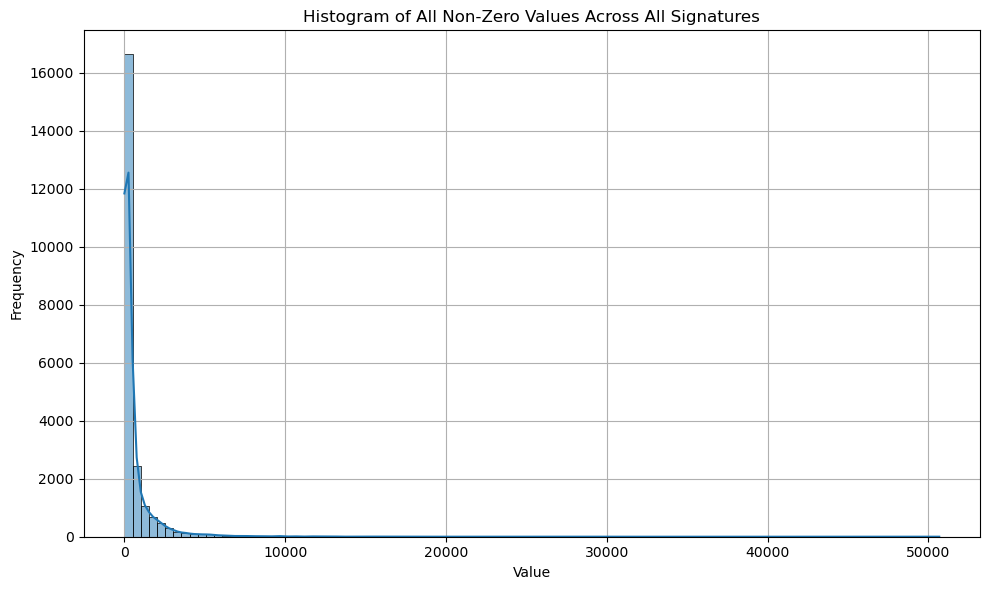

In [232]:
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten all non-zero values into one array
non_zero_values = pangyn_Y[pangyn_Y != 0].stack().values
print(non_zero_values)

# Plot the histogram
plt.figure(figsize=(10, 6))

# Add axis limits
# plt.xlim(-2, 5000)      # Adjust x-axis range
# plt.ylim(0, 5000)     # Adjust y-axis range

sns.histplot(non_zero_values, bins=100, kde=True)
plt.title("Histogram of All Non-Zero Values Across All Signatures")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

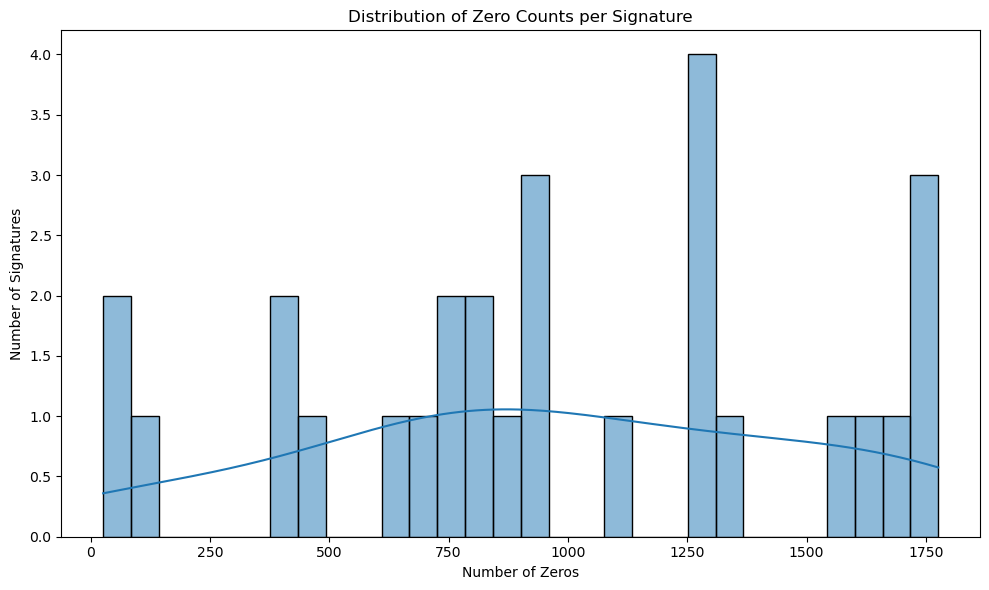

In [233]:
plt.figure(figsize=(10, 6))
sns.histplot(count_df["0"], bins=30, kde=True)
plt.title("Distribution of Zero Counts per Signature")
plt.xlabel("Number of Zeros")
plt.ylabel("Number of Signatures")
plt.tight_layout()
plt.show()